In [ ]:
import time
import copy as cp

import numpy as np
from numba import jit, njit
PI = np.pi

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
plt.rcParams['image.cmap']='cool'  ## set a global cmap: 'cool' ,   'twilight_shifted', 'hsv', 'jet'
cmap = 'cool'
alpha = 0.9


In [ ]:
def plot_2D(f, x_label = '$t$', y_label = '$x$', title='$f(x,y)$'):
    
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.imshow(f, cmap='cool', origin='lower')
    ax.set_xlabel(x_label, fontsize=15);
    ax.set_ylabel(y_label, fontsize=15);
    ax.set_title(title, fontsize = 20) ;
    plt.show()


def plot_3D(x,y,z, x_label = '$t$', y_label ='$x$', z_label = '$u$', title='$u(t,x)$', elev=15., azim=0):  
    
    fig = plt.figure( figsize = (10, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap = cmap, alpha = alpha)
    ax.set_xlabel(x_label, fontsize=15);
    ax.set_ylabel(y_label, fontsize=15);
    ax.set_zlabel(z_label, fontsize=15);
    ax.set_title(title, fontsize = 20);
    ax.view_init(elev=elev, azim=azim)
        
    plt.show()
    
    

    
    
def plot_3D_animation(x,y,z, x_label = '$t$', y_label ='$x$', z_label = '$u$', title='$u(t,x)$'):  
       
    fig = plt.figure( figsize = (10, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap = cmap, alpha = alpha)
    ax.set_xlabel(x_label, fontsize=15);
    ax.set_ylabel(y_label, fontsize=15);
    ax.set_zlabel(z_label, fontsize=15);
    ax.set_title(title, fontsize = 20);
    ax.axis('off')
   
    ## For animation: rotation 
    for ii in range(0, 360, 5):
        ax.view_init(elev=15., azim=ii)
        fig.savefig("test_%d.png" % ii)

## Partial differential equations - wave-type equations

Scheme: 
1. Discretize the spatial dimention: $u_n=u(x_n,t)$  (for example $x_n=nh$) 

2. write a system of $N$ second order (or $2N$ first order) time differential equations:
$$\partial_{tt}u_n=D_{nm}u_m-F_n$$


* write a system of $𝑁$ second order equations:

    $$ u_n''\approx \frac{u_{n-1}-2u_n+u_{n+1}}{h^2}$$

    $$D_{n,m} = \delta_{n-1, m}- 2\delta_{n, m} +\delta_{n+1, m}  \cdot \frac{1}{dx^2}, \qquad n,m = 0,1,2,3,..., N-1$$
    

* write a system of $2 𝑁$ first order equations:

$$ \vec{v}=(u, \partial_x u)$$

$$ \partial_x \vec{v}=(\partial_x u, \partial_{xx} u)$$

$$ u'_n=\frac{u_{n+1}-u_{n-1}}{2h}$$

$$D_{n,m} = ? , \qquad n,m = 0,1,2,3,..., 2N-1$$


3. use some time-stepping method to solve the system for given initial conditions $u(x, 0), \partial_t u(x, 0)$ and boundary conditions, such as $u(0,t)=f(x)$ and $u(L,t)=g(x)$.
* Runge-Kutta method
* simplectic method

4. Important issue: stability.

For explicit methods time step must be adjusted to the highest eigenvalue of $D_{nm}$
(a saw-type function).
$\lambda \approx (dx)^{−2}$

## sine-Gordon model:

$$ \partial_{tt}u = \partial_{xx}u - \sin(u)$$

1. initial conditions:

* $u(x, 0) = 0 \qquad (position)$

* $\partial_t u(x, 0) =  \left\{\begin{array}{rcl} \omega  \qquad for \qquad x = 0 \\ 0  \qquad for \qquad x>0 \end{array} \right. \qquad (velocity)$

2. boundary conditions:

* $u(0, t) = \sin( \omega t) \qquad $

* $u(L, t) = -\sin( \omega t) \qquad $

(sth like a bunch of pendulums on a straight line, with the first and last pendulum rotating)

### Implementation:

1. spatial dimention discretization:

* $ x_n = n\cdot h \qquad n=0,1,2,3,...,N-1$

* $ u_n(t) = u(t, x_n)$



2. discretized initial conditions:

* $u_n(0) = 0 \qquad (position)$

* $\partial_t u_n(0) =  \left\{\begin{array}{rcl} \omega  \qquad for \qquad n = 0 \\ 0  \qquad for \qquad n>0 \end{array} \right. \qquad (velocity)$




3. discretized boundary conditions:

* $u_0(t) = \sin( \omega t) \qquad $

* $u_{N-1}(t) = -\sin( \omega t) \qquad $




4. write a system of $𝑁$ second order equations:

$$ u_n''\approx \frac{u_{n-1}-2u_n+u_{n+1}}{h^2}$$

$$D_{n,m} = \delta_{n-1, m}- 2\delta_{n, m} +\delta_{n+1, m}$$

$$ \partial_{tt}u_n =  \frac{u_{n-1}-2u_n+u_{n+1}}{h^2} - \sin(u_n) = D_{n,m}u_m - sin(u_n)$$

where:
$$D_{n,m} = \delta_{n-1, m}- 2\delta_{n, m} +\delta_{n+1, m}, \qquad n,m = 0,1,2,3,..., Nx$$

5. 
* $n,m = 0,1,2,3,..Nx$ - indexing of spatial coordinates
* $i,j = 0,1,2,3,..Nt$ - indexing of temporal coordinates


In [ ]:
def get_D_second_order(N):
    
    '''
        𝐷𝑛,𝑚 = 𝛿𝑛−1,𝑚 − 2𝛿𝑛,𝑚 + 𝛿𝑛+1,𝑚
        No boundary conditions included
        
    '''
    D = np.diagflat( np.ones(N) * (-2))
    
    for i in range(1,N-1):
        D[i][i+1] = 1
        D[i][i-1] = 1
    
    return D

### simplectic method:
$$ \partial_t u^i = v^i $$
$$ \partial_{tt} u^i = \partial_t v^i = G(u^i)$$

multistep:
$$ u^{i+1/2} = u^i + \frac12 v^i dt = k^i $$
$$ v^{i+1} = v^i + G\left(u_{i+1/2}\right) dt $$
$$ u^{i+1} = u^{i+1/2}+\frac12 v^i dt $$

In our case this is:

$$ G(u^i) =  G(u^i_n) = D_{n,m}u_m - \sin(u_n) $$

$$ u^{i+1/2}_n = u^i_n + \frac12 v^i_n \cdot dt = k^i_m $$

$$ v^{i+1}_n = v^i_n + G\left(u^{i+1/2}_n\right) \cdot dt $$

$$ u^{i+1}_n = u^{i+1/2}_n +\frac12 v^i_n \cdot dt $$

In [ ]:
Nx= 20   ##(50, 40000)
Nt = 10000

T = 1
L = 1

ω = 0.1

xx = np.linspace(0, L, Nx+1)
tt = np.linspace(0, T, Nt+1)

x,t = np.meshgrid(xx,tt)

dx = xx[1] - xx[0]
dt = tt[1] - tt[0]

D = get_D_second_order(Nx+1)
plt.matshow(D, cmap='bwr', vmin=-4, vmax=4) 

In [ ]:
dx, dt, (1/dx**2 * dt)

In [ ]:
u = np.empty((Nt+1,Nx+1))
v = np.empty((Nt+1,Nx+1))  ## v = du/dt 

print(u.shape, v.shape)

# set initial conditions at t=0 for position u(t,x)
u[0,:] = 0

# set initial conditions at t=0 for velocity u'(t,x)
v[0,0] = ω 
v[0,-1] = ω 
v[0, 1:-1] = 0


## set boundary conditions:
u[:,0] = np.sin(ω * tt)   
u[:,Nx] = - np.sin(ω * tt) 

In [ ]:
## simplectic method

def G(D, u, dx):       
    return 1/(dx*dx) * np.matmul(D, u) - np.sin(u)


for i in range(0,Nt):
    #for n in range(1,Nx):
        
    tmp = np.empty(Nx+1)  
    tmp[:] = u[i, :] + 0.5 * v[i, :] * dt       
    v[i+1,:] = v[i, :] + G(D, tmp, dx)* dt
    u[i+1,:] = tmp + 0.5 * v[i, :]* dt
    
    """
    #print("\n\n i = {:} \t t = {:} \t ".format(i, tt[i]))    
    print("u[i] = {:}".format(u[i, :]))
    print("v[i] = {:}".format(v[i, :]))    
    print("v[i] = {:}".format(v[i, :]))
    print("v[i+1] = {:}".format(v[i+1, :]))
    print("u[i+1] = {:}".format(u[i+1, :]))
    """



In [ ]:
plot_3D(t,x,u, elev=90., azim=120)


In [ ]:
plot_3D(t,x,u, elev=25., azim=220)


W przypadku three-point stencil wg moich testów najszybciej liczenie pochodnej (dla punktów 1:Nx-1) odbywa się poprzez

Du = (u[i, :-2]-2*u[i, 1:-1]+u[i, 2:])/dx2

Nieco wolniejsze (i bez możliwości uogólnienia na dokładniejsze schematy), ale bardziej eleganckie jest użycie Du = np.diff(u[i,:], 2)/dx2. Można jeszcze użyć np.convolve, albo mnożenia przez maciersz (w przypadku macierzy dużych powinna to być macierz rzadka), ale to wszystko wolniejsze od zwykłych slice’ów.


Druga rzecz to to, że nadpisuje Pani warunki brzegowe w trakcie ewolucji, czego lepiej unikać jeśli nie ma odpowiedniego równania ewolucyjnego na brzegu (np. symetria, periodyczność itp). Jeśli u[:,0] i u[:,Nx] są ustalone, to należy ograniczyć liczenie u i v do v[i+1,1:-1] i u[i+1,1:-1].

Kolejna uwaga to to, że jeśli liczy Pani tmp to tam też powinno się uwzględnić warunki brzegowe (wg oznaczeń z pliku) u^{i+1/2}_0 i u^{i+1/2}_Nx, co odpowiada np.sin(ω (tt[i]+0.5​dt)).





In [ ]:
u = np.empty((Nt+1,Nx+1))
v = np.empty((Nt+1,Nx+1))  ## v = du/dt 

print(u.shape, v.shape)

# set initial conditions at t=0 for position u(t,x)
u[0,:] = 0

# set initial conditions at t=0 for velocity u'(t,x)
v[0,0] = ω 
v[0,-1] = ω 
v[0, 1:-1] = 0


## set boundary conditions:
u[:,0] = np.sin(ω * tt)   
u[:,Nx] = - np.sin(ω * tt) 

In [ ]:
## simplectic method V2

def G(D, u, dx):       
    return 1/(dx*dx) * np.matmul(D, u) - np.sin(u)


for i in range(0,Nt):
    #for n in range(1,Nx):
        
    tmp = np.empty(Nx+1)  
    tmp[:] = u[i, :] + 0.5 * v[i, :] * dt       
    
    v[i+1,:] = v[i, :] + (u[i, :-2]-2*u[i, 1:-1]+u[i, 2:])/(dx*dx) * dt  
    
    u[i+1,:] = tmp + 0.5 * v[i, :]* dt
    
 


### Runge–Kutta–Nyström Methods:

for $$y'' = f(x,y,y')$$ initial value problems $y(x_0) = y_0$, $y'(x_0) = y'_0$  we may use Runge-Kutta-Nyström method:

$$y_{n+1} = y_n + hy'_n + h^2 \sum _{i=0}^m \bar{b}_i k'_i$$

$$y'_{n+1} = y'_n + h \sum _{i=0}^m b_i k'_i$$


$$ k'_i = f(x_n + c_i h, y_n + c_i h y'_n + h^2 \sum _{j=1}^m \bar{a}_{ij} k'_j)$$

$m$  = number of stages


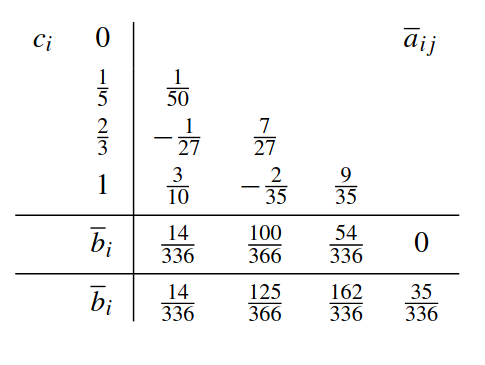